## Step 1: Validate the files

This data set is provided by Kaggle as part of the `Titanic: Machine Learning from Disaster!` challenge.
I have already downloaded the data, and it can be found in the `./kaggle/input/titanic` dir associated with this notebook.

In [233]:
import os

data_dir = "kaggle/input/titanic/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [234]:
[f"{kaggle_input_dir}{file}" for file in os.listdir(kaggle_input_dir)]

['kaggle/input/titanic/gender_submission.csv',
 'kaggle/input/titanic/train.csv',
 'kaggle/input/titanic/test.csv']

## Step 2: Explore the data

Let's first import some of the packages we'll need, then we can explore our data sets.

In [235]:
import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.model_selection

In [236]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [237]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [238]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


We can already see that the data is organized very well, and there are some obvious features we can work with, such as `Age`, `Sex`, and `Pclass` (ticket class), `sibsp` (# of siblings / spouses aboard the Titanic), and `parch` (# of parents / children aboard the Titanic).

Other features like `Name`, might prove to be less important.

We also see our `Classifier` labeled here as `Survived`. This is obviously missing from the test set.

We can aso engineer some new features from this data, for instance; We can create a `child` feature based on age, as well as an `senior` feature.

## Step 3: Visualize the data

Since we have some theories about the data, we can visualize the data to get a better idea of which features are really correlated to survival. Let's start with `Pclass`

In [239]:
pclass_np = train[["Survived", "Pclass"]].values
survivors_pclass = pclass_np[pclass_np[:,0] == 1,:][:,1]
non_survivors_pclass = pclass_np[pclass_np[:,0] == 0,:][:,1]
print(non_survivors_pclass[:10])

[3 3 3 1 3 3 3 3 3 3]


(array([136.,  87., 119.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

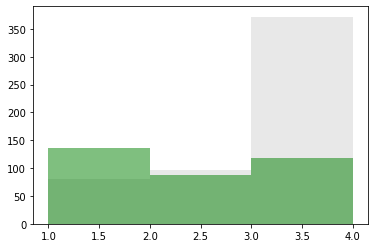

In [240]:
pclass_bins = range(1, 5)
plt.hist(non_survivors_pclass, bins=pclass_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_pclass, bins=pclass_bins, color="green", alpha=0.5)

We can see that our hunch was correct regarding `Pclass`, 3rd class passengers are much more likely not to survive, while 1st class passengers are the most likely to survive.

Let's look at `Age`, `Sex`, `SibSp`, and `Parch` next.

In [241]:
age_np = train[["Survived", "Age"]].values
survivors_age = age_np[age_np[:,0] == 1,:][:,1]
non_survivors_age = age_np[age_np[:,0] == 0,:][:,1]
# remove NaN
survivors_age = survivors_age[~np.isnan(survivors_age)]
non_survivors_age = non_survivors_age[~np.isnan(non_survivors_age)]
print(non_survivors_age[:10])

[22. 35. 54.  2. 20. 39. 14.  2. 31. 35.]


(array([20.,  9.,  4., 15., 27., 36., 30., 36., 34., 17., 12., 12., 14.,
         7.,  5.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
        69, 73, 77, 81, 85, 89, 93, 97]),
 <a list of 24 Patch objects>)

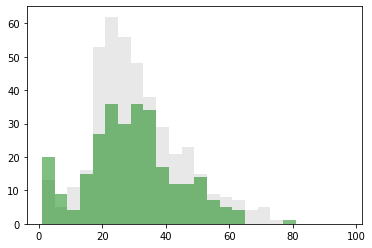

In [242]:
age_bins = range(1, 100, 4)
plt.hist(non_survivors_age, bins=age_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_age, bins=age_bins, color="green", alpha=0.5)

Again we find something interesting, while most age groups have proportional mortality rates to number of passengers, young children have significantly *higher* survival rates, while certain older groups have significantly *higher* mortality rates. So `Senior` and `Child` might prove to be good features to engineer.

In [243]:
sex_np = train[["Survived", "Sex"]].values
survivors_sex = sex_np[sex_np[:,0] == 1,:][:,1]
non_survivors_sex = sex_np[sex_np[:,0] == 0,:][:,1]
print(non_survivors_sex[:10])

['male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'female']


(array([109.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 233.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

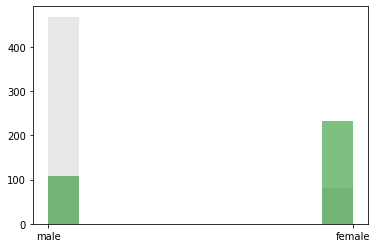

In [244]:
plt.hist(non_survivors_sex, color="lightgrey", alpha=0.5)
plt.hist(survivors_sex, color="green", alpha=0.5)

Again we see a trend, males are likely to not survive, while females are likely to survive.

In [245]:
sibsp_np = train[["Survived", "SibSp"]].values
survivors_sibsp = sibsp_np[sibsp_np[:,0] == 1,:][:,1]
non_survivors_sibsp = sibsp_np[sibsp_np[:,0] == 0,:][:,1]
print(non_survivors_sibsp[:10])

[1 0 0 0 3 0 1 0 4 1]


(array([112.,  13.,   4.,   3.,   0.,   0.,   0.,   0.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

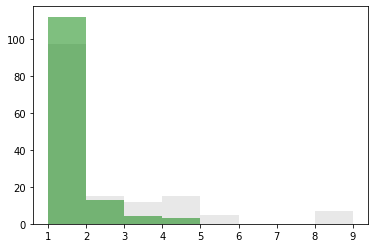

In [246]:
sibsp_bins = range(1, 10)
plt.hist(non_survivors_sibsp, bins=sibsp_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_sibsp, bins=sibsp_bins, color="green", alpha=0.5)

We find a similar story for `SibSp`, a higher `SibSp` indicates a higher mortality rate.

In [247]:
parch_np = train[["Survived", "Parch"]].values
survivors_parch = parch_np[parch_np[:,0] == 1,:][:,1]
non_survivors_parch = parch_np[parch_np[:,0] == 0,:][:,1]
print(non_survivors_parch[:10])

[0 0 0 0 1 0 5 0 1 0]


(array([65., 40.,  3.,  0.,  1.,  0.]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <a list of 6 Patch objects>)

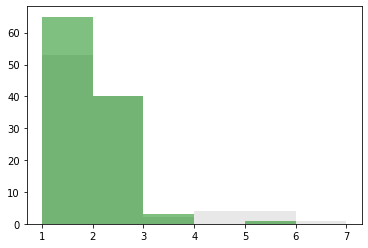

In [248]:
parch_bins = range(1, 8)
plt.hist(non_survivors_parch, bins=parch_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_parch, bins=parch_bins, color="green", alpha=0.5)

While less significant than the previous relations, we do see a relationship between high `Parch` and mortality.

In [249]:
embarked_np = train[["Survived", "Embarked"]].values
survivors_embarked = embarked_np[embarked_np[:,0] == 1,:][:,1].astype(str)
non_survivors_embarked = embarked_np[embarked_np[:,0] == 0,:][:,1].astype(str)
# remove NaN
survivors_embarked = survivors_embarked[survivors_embarked != 'nan']
non_survivors_embarked = non_survivors_embarked[non_survivors_embarked != 'nan']
print(non_survivors_embarked[:10])

['S' 'S' 'Q' 'S' 'S' 'S' 'S' 'S' 'Q' 'S']


(array([217.,   0.,   0.,   0.,   0.,  30.,   0.,   0.,   0.,  93.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

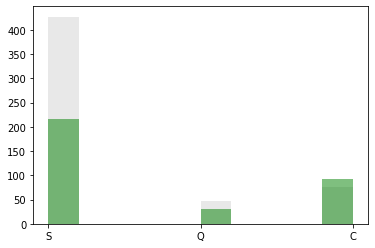

In [250]:
plt.hist(non_survivors_embarked, color="lightgrey", alpha=0.5)
plt.hist(survivors_embarked, color="green", alpha=0.5)

Although we didn't initial think `Embarked` would prove valuable, we do see some correlation here, though it may not be important.

In [251]:
fare_np = train[["Survived", "Fare"]].values
survivors_fare = fare_np[fare_np[:,0] == 1,:][:,1]
non_survivors_fare = fare_np[fare_np[:,0] == 0,:][:,1]
print(non_survivors_fare[:10])
print(survivors_fare.max())

[ 7.25    8.05    8.4583 51.8625 21.075   8.05   31.275   7.8542 29.125
 18.    ]
512.3292


(array([75., 71., 64., 18.,  4., 27.,  6., 19., 14.,  4.,  5.,  6.,  0.,
         6.,  2.,  4.,  2.,  0.,  0.,  0.,  0.,  3.,  3.,  0.,  1.,  0.,
         4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
         0.,  0.]),
 array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
        131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
        261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
        391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
        521, 531, 541]),
 <a list of 54 Patch objects>)

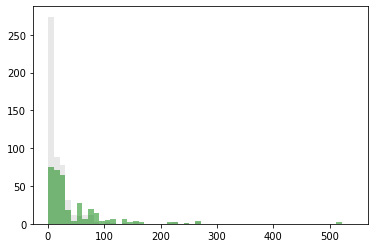

In [252]:
fare_bins = range(1, 550, 10)
plt.hist(non_survivors_fare, bins=fare_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_fare, bins=fare_bins, color="green", alpha=0.5)

We clearly see some correlation for `Fare`, though this might already be reflected in `Pclass`. We can experiment with this feature.

## Step 4: Algorithm choice and benchmark

With the above features in mind, an binary logistic XGBoost model might fit this problem well, we need a model that can perform well even on a limited feature set and with a moderte sample size. The model also needs to support binary classification, XGBoost should make for a fine choice.

Of course, we still need a benchmark to base our models performance on, we will aim for a relatively high accuracy (calculated by Kaggle) of about 80%.

## Step 5: Preprocessing the data

We've seen that our data can use some cleaning in order to "fix" missing data. Where possible, we will replace data using averages to avoid dropping rows. Let's start by looking at our data again.

In [253]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Let's go ahead and get rid of the features we've not selected for use in our model.

In [254]:
def get_df_with_base_features(df, selected_features):
    '''Returns a given DataFrame with only it's selected features.
       :param df: A dataframe
       :param selected_features: An array of selected features that correspond to certain columns in `df`
       :return: DataFrame: features_df'''
    
    features_df = df[selected_features]
    return features_df

In [255]:
selected_test_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
selected_train_features = ["Survived"] + selecsted_test_features

NameError: name 'selecsted_test_features' is not defined

In [256]:
test_base_features_df = get_df_with_base_features(test, selected_test_features)
train_base_features_df = get_df_with_base_features(train, selected_train_features)

In [257]:
train_base_features_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [258]:
test_base_features_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Now that we have our feature data frames, we can normalize our data.

In [267]:
from sklearn.preprocessing import MinMaxScaler

def process_features(df, selected_features):
    '''Returns a given DataFrame with processed features.
       :param df: A dataframe
       :param selected_features: An array of selected features that correspond to certain columns in `df`
       :return: DataFrame: processed_df'''
    
    embarked_dict = {
        "C": 1,
        "Q": 2,
        "S": 3
    }
    
    sex_dict = {
        "female": 1,
        "male": 2
    }
    
    processed_df = df.copy()
    
    if 'Embarked' in processed_df.columns:
        # Replace nan with S, the most frequent and normal Embarked value
        processed_df.replace(np.nan, "S")
        processed_df["Embarked"] = processed_df["Embarked"].map(embarked_dict)

    if 'Sex' in processed_df.columns:
        processed_df["Sex"] = processed_df["Sex"].map(sex_dict)

    # Finally we scale the numeric columns
    scaler = MinMaxScaler()
    processed_df = pd.DataFrame(scaler.fit_transform(processed_df.astype(float)))
    processed_df.columns = df.columns
    processed_df.index = df.index

    return processed_df



In [268]:
processed_test_df = process_features(test_base_features_df, selected_test_features)
processed_train_df = process_features(train_base_features_df, selected_train_features)

In [269]:
processed_test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


In [270]:
processed_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


With that, we have our selected features, processed for our model.